# Parsing data directly from Google and performing LDA

In [59]:
import warnings
warnings.filterwarnings("ignore")

# !pip install bs4
import urllib.request
from bs4 import BeautifulSoup
query = input("Enter company name ")
query = query.replace(" ","+")
url = "http://www.google.com/search?q="+str(query)
print (url)
req = urllib.request.Request(url, headers={'User-Agent' : "Magic Browser"})
response = urllib.request.urlopen( req )
html = response.read()
soup = BeautifulSoup(html, 'html.parser')
import re
all_links=[]
for link in soup.findAll('a'):
    all_links.append(link.get('href'))
# aspx_links=soup.findAll('a', attrs={'href': re.compile(".aspx")})
# aspx_links = [str(x) for x in aspx_links]
# import re
# links=[]
# for x in aspx_links:
#     m = re.search('https:(.+?)aspx', x)
#     if m:
#         found = m.group(1)
#     links.append(found)
# links= list(set(links))
# final_links = []

Enter company name tinder
http://www.google.com/search?q=tinder


In [60]:
print(len(all_links))
all_links[0]

69


'/?sa=X&ved=0ahUKEwiiwr24mezlAhXt6nMBHfBVD5sQOwgC'

In [61]:
imp_links = []
for x in all_links:
    if x.startswith("/url"):
        imp_links.append(x)

In [62]:
print(len(imp_links))
imp_links[0]

19


'/url?q=https://tinder.com/%3Flang%3Den&sa=U&ved=2ahUKEwiiwr24mezlAhXt6nMBHfBVD5sQFjAAegQICBAB&usg=AOvVaw3KtbetPfse0jRwwIjtHBPi'

In [63]:
final_links = []
for x in imp_links:
    final_links.append("https://google.com"+x)

In [64]:
final_links[0]

'https://google.com/url?q=https://tinder.com/%3Flang%3Den&sa=U&ved=2ahUKEwiiwr24mezlAhXt6nMBHfBVD5sQFjAAegQICBAB&usg=AOvVaw3KtbetPfse0jRwwIjtHBPi'

In [65]:
text=[]
for i in range(len(final_links)):
    req = urllib.request.Request(final_links[i],headers = {'User-Agent' : 'Magic Browser'})
    response = urllib.request.urlopen(req)
    html = response.read()
    soup = BeautifulSoup(html,'lxml')
    for j in range(len(soup.find_all('p'))):
        text.append(soup.find_all('p')[j].get_text())

In [66]:
len(text)

323

In [67]:
#NLTK for cleaning
from nltk.corpus import stopwords
from string import punctuation
stuff_to_be_removed = list(stopwords.words("english"))+list(punctuation)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to D:\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [68]:
def my_tokenizer(s):
    s = s.lower()
    text = nltk.tokenize.word_tokenize(s)
    text = [t for t in text if len(t) > 2]
    text = [lemmatizer.lemmatize(y) for y in text if y not in stuff_to_be_removed]
    text = [t for t in text if not any(c.isdigit() for c in t)]
    
    return text

final_text = [my_tokenizer(s) for s in text]

In [69]:
import gensim
from gensim.corpora import dictionary
from gensim import corpora
from pprint import pprint

id2word = corpora.Dictionary(final_text)
mycorpus = [id2word.doc2bow(s) for s in final_text]
lda_model = gensim.models.ldamodel.LdaModel(corpus=mycorpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [70]:
pprint(lda_model.print_topics())

[(0,
  '0.049*"app" + 0.027*"user" + 0.021*"let" + 0.019*"tinder" + 0.018*"love" + '
  '0.018*"people" + 0.018*"match" + 0.012*"..." + 0.012*"right" + 0.011*"two"'),
 (1,
  '0.021*"accepting" + 0.017*"apple" + 0.014*"become" + 0.013*"network" + '
  '0.013*"pet" + 0.013*"tinder" + 0.012*"india" + 0.012*"make" + '
  '0.011*"branded" + 0.011*"gifs"'),
 (2,
  '0.027*"partner" + 0.020*"say" + 0.018*"farm" + 0.018*"animal" + 0.014*"try" '
  '+ 0.013*"twitter" + 0.013*"code" + 0.013*"add" + 0.013*"according" + '
  '0.012*"copying"'),
 (3,
  '0.029*"find" + 0.028*"right" + 0.026*"tinder" + 0.015*"country" + '
  '0.012*"community" + 0.011*"app" + 0.010*"case" + 0.010*"swipe" + '
  '0.010*"apps" + 0.009*"missed"'),
 (4,
  '0.026*"tweet" + 0.021*"feature" + 0.020*"popular" + 0.018*"location" + '
  '0.016*"someone" + 0.016*"web" + 0.015*"match" + 0.013*"local" + 0.011*"get" '
  '+ 0.011*"break"'),
 (5,
  '0.048*"tinder" + 0.023*"app" + 0.014*"relationship" + 0.013*"twitter" + '
  '0.010*"developer

In [71]:
doc_lda = lda_model[mycorpus]

In [72]:
print('\nPerplexity: ', lda_model.log_perplexity(mycorpus)) 
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=final_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.706347817299338

Coherence Score:  0.4146047380825002


In [73]:
import os
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, mycorpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.158274  0.014772       1        1  34.016354
5      0.067202 -0.085710       2        1  14.983974
0      0.080560  0.046199       3        1  13.123017
7      0.091487  0.013279       4        1  10.461841
4     -0.161630  0.153452       5        1   8.409204
2     -0.110111 -0.192906       6        1   7.548364
3      0.015518  0.058927       7        1   7.015873
1     -0.141300 -0.008013       8        1   4.441381, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
0     Default   90.000000         app   90.000000  30.0000  30.0000
25    Default   35.000000       right   35.000000  29.0000  29.0000
107   Default  120.000000        user  120.000000  28.0000  28.0000
741   Default   15.000000        find   15.000000  27.0000  27.0000
60    Default  207.000000      tinder  207.000000  26.0000  26.0000
606   Default   16.000000     partner   16.000000  25.0000  25.0000
1041  Default   17.000000         let   17.000000  24.0000  24.0000
946   Default   21.000000       tweet   21.000000  23.0000  23.0000
188   Default   37.000000        time   37.000000  22.0000  22.0000
118   Default   30.000000         one   30.000000  21.0000  21.0000
1042  Default   15.000000        love   15.000000  20.0000  20.0000
941   Default   18.000000     twitter   18.000000  19.0000  19.0000
14    Default   59.000000       match   59.000000  18.0000  18.0000
66    Default   12.000000      single   12.000000  17.0000  17.0000
465   Default   26.000000    location   26.000000  16.0000  16.0000
23    Default   11.000000     popular   11.000000  15.0000  15.0000
50    Default   34.000000     profile   34.000000  14.0000  14.0000
38    Default   24.000000     feature   24.000000  13.0000  13.0000
76    Default   36.000000     account   36.000000  12.0000  12.0000
20    Default   25.000000      people   25.000000  11.0000  11.0000
955   Default   10.000000         say   10.000000  10.0000  10.0000
17    Default   33.000000     million   33.000000   9.0000   9.0000
54    Default   14.000000     someone   14.000000   8.0000   8.0000
189   Default   13.000000        want   13.000000   7.0000   7.0000
1452  Default   10.000000      google   10.000000   6.0000   6.0000
74    Default   11.000000         web   11.000000   5.0000   5.0000
1395  Default    9.000000        farm    9.000000   4.0000   4.0000
1391  Default    9.000000      animal    9.000000   3.0000   3.0000
58    Default   34.000000       swipe   34.000000   2.0000   2.0000
1353  Default    9.000000       india    9.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
1374   Topic8    2.851482        felt    3.652687   2.8666  -4.5491
1379   Topic8    2.851482    whatsapp    3.652687   2.8666  -4.5491
1375   Topic8    2.851482        gifs    3.652687   2.8666  -4.5491
1376   Topic8    2.851482      hoping    3.652687   2.8666  -4.5491
1377   Topic8    2.851482    presence    3.652687   2.8666  -4.5491
1378   Topic8    2.851482     sticker    3.652687   2.8666  -4.5491
1430   Topic8    2.851451       fully    3.652689   2.8666  -4.5491
1431   Topic8    2.851451       peeve    3.652689   2.8666  -4.5491
1432   Topic8    2.851421        folk    3.652690   2.8666  -4.5491
1437   Topic8    2.851421       young    3.652690   2.8666  -4.5491
1436   Topic8    2.851421  revelation    3.652690   2.8666  -4.5491
1435   Topic8    2.851421      pandya    3.652690   2.8666  -4.5491
1434   Topic8    2.851421    outraged    3.652690   2.8666  -4.5491
1433   Topic8    2.851421       older    3.652690   2.8666  -4.5491
1421   Topic8    2.851287       truly    3.652725   2.8665  -4.5491
1417   Topic8    2.851287    competes    3.652725   2.8665  -4.5491
1419   Topic8    2.851287       madly    3.652725   2.8665  -4.5491
1418   Topic8    

In [74]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=mycorpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [75]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=mycorpus, texts=final_text, start=2, limit=40, step=6)

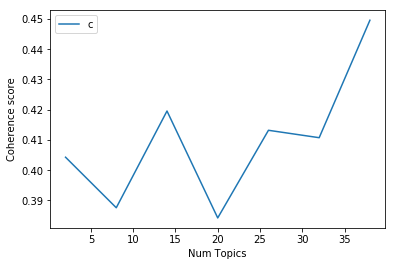

In [76]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [78]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4043
Num Topics = 8  has Coherence Value of 0.3876
Num Topics = 14  has Coherence Value of 0.4196
Num Topics = 20  has Coherence Value of 0.3842
Num Topics = 26  has Coherence Value of 0.4132
Num Topics = 32  has Coherence Value of 0.4107
Num Topics = 38  has Coherence Value of 0.4496


In [79]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.048*"tinder" + 0.045*"user" + 0.024*"match" + 0.016*"day" + 0.015*"app" + '
  '0.015*"swipe" + 0.013*"time" + 0.013*"profile" + 0.011*"one" + 0.011*"per"'),
 (1,
  '0.026*"tweet" + 0.022*"add" + 0.020*"location" + 0.013*"learn" + '
  '0.010*"one" + 0.010*"tinder" + 0.010*"find" + 0.010*"around" + '
  '0.009*"right" + 0.009*"partner"'),
 (2,
  '0.050*"tinder" + 0.018*"twitter" + 0.014*"user" + 0.012*"information" + '
  '0.012*"may" + 0.011*"app" + 0.010*"tweet" + 0.009*"location" + '
  '0.008*"hiccup" + 0.008*"momentary"'),
 (3,
  '0.032*"user" + 0.026*"boost" + 0.026*"tinder" + 0.018*"profile" + '
  '0.014*"feature" + 0.011*"minute" + 0.009*"plus" + 0.008*"make" + '
  '0.007*"time" + 0.007*"match"'),
 (4,
  '0.037*"user" + 0.028*"tinder" + 0.024*"like" + 0.022*"super" + '
  '0.015*"profile" + 0.013*"match" + 0.012*"right" + 0.011*"app" + '
  '0.010*"swipe" + 0.009*"get"'),
 (5,
  '0.022*"tinder" + 0.015*"best" + 0.013*"swipe" + 0.013*"instantly" + '
  '0.011*"twitter" + 0.010

In [80]:
import pandas as pd
def format_topics_sentences(ldamodel=lda_model, corpus=mycorpus, texts=text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=mycorpus, texts=final_text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.9768,"tinder, match, like, app, per, dating, tweet, new, right, feature","[billion, match, date, tinder®, world, popular, app, meeting, new, people, think, dependable, wi..."
1,1,6.0,0.9798,"tinder, match, like, app, per, dating, tweet, new, right, feature","[match, chat, date, tinder, easy, fun—use, swipe, right™, feature, like, someone, use, swipe, le..."
2,2,0.0,0.8097,"tinder, user, match, day, app, swipe, time, profile, one, per","[welcome, tinder—the, largest, hottest, community, single, world, shy, come]"
3,3,7.0,0.9156,"tinder, user, location, match, app, time, know, found, tweet, data","[download, tinder, app, io, android, visit, tinder.com, use, tinder, web]"
4,4,0.0,0.0714,"tinder, user, match, day, app, swipe, time, profile, one, per",[]
5,5,0.0,0.0714,"tinder, user, match, day, app, swipe, time, profile, one, per",[]
6,6,0.0,0.0714,"tinder, user, match, day, app, swipe, time, profile, one, per",[]
7,7,0.0,0.9855,"tinder, user, match, day, app, swipe, time, profile, one, per","[tinder, location-based, social, search, mobile, app, web, application, often, used, dating, ser..."
8,8,12.0,0.9596,"tinder, ..., billion, match, million, company, campaign, loading, quarter, iac","[tinder, launched, within, startup, incubator, hatch, lab, joint, venture, iac, mobile, developm..."
9,9,12.0,0.8673,"tinder, ..., billion, match, million, company, campaign, loading, quarter, iac","[tinder, university, college, student, feature, came]"


In [81]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9925,"tinder, user, match, day, app, swipe, time, profile, one, per","[tinder, primary, companion, site, facebook, tinder, user, originally, required, connect, facebo..."
1,1.0,0.9911,"tweet, add, location, learn, one, tinder, find, around, right, partner","[august, new, york-based, model, natasha, aponte, made, headline, reported, amassed, dozen, men,..."
2,2.0,0.9818,"tinder, twitter, user, information, may, app, tweet, location, hiccup, momentary","[march, tinder, released, paid, service, tinder, plus, feature, allowing, unlimited, match, wher..."
3,3.0,0.9865,"user, boost, tinder, profile, feature, minute, plus, make, time, match","[tinder, began, testing, boost, functionality, september, australia, feature, went, live, user, ..."
4,4.0,0.9857,"user, tinder, like, super, profile, match, right, app, swipe, get","[october, tinder, released, super, like, feature, worldwide, allows, non-paying, user, super, li..."
5,5.0,0.9727,"tinder, best, swipe, instantly, twitter, app, happening, catch, unfold, story","[tinder, founded, within, startup, incubator, hatch, lab, sean, rad, jonathan, badeen, justin, m..."
6,6.0,0.9967,"tinder, match, like, app, per, dating, tweet, new, right, feature","[billion, match, date, tinder®, world, popular, app, meeting, new, people, think, dependable, wi..."
7,7.0,0.9889,"tinder, user, location, match, app, time, know, found, tweet, data","[august, two, engineer, found, another, flaw, showed, exact, location, user, match, location, up..."
8,8.0,0.9873,"tinder, online, relationship, problem, try, hmm, server, reaching, mateen, rad","[august, journalist, nancy, sale, wrote, vanity, fair, tinder, operates, within, culture, user, ..."
9,9.0,0.9879,"tinder, user, want, swipebuster, first, profile, rejected, database, search, like","[march, website, called, swipebuster, launched, allows, anyone, see, recently, someone, else, lo..."


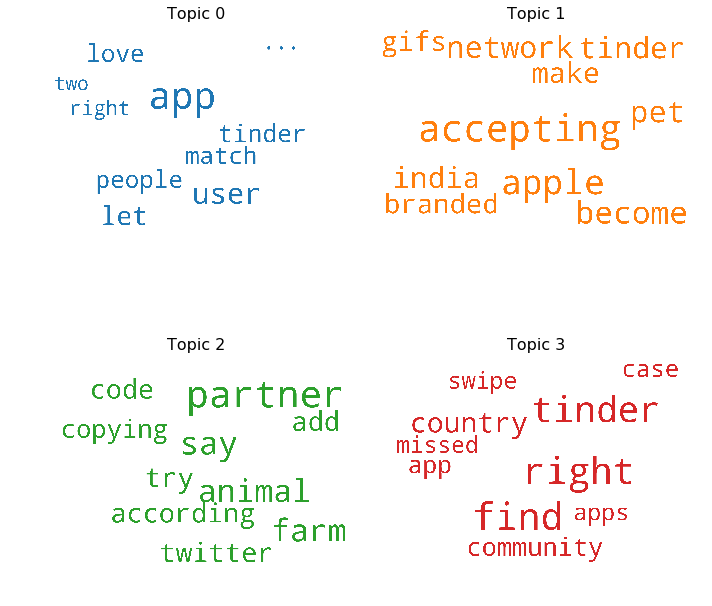

In [82]:
#!pip install wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stuff_to_be_removed,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

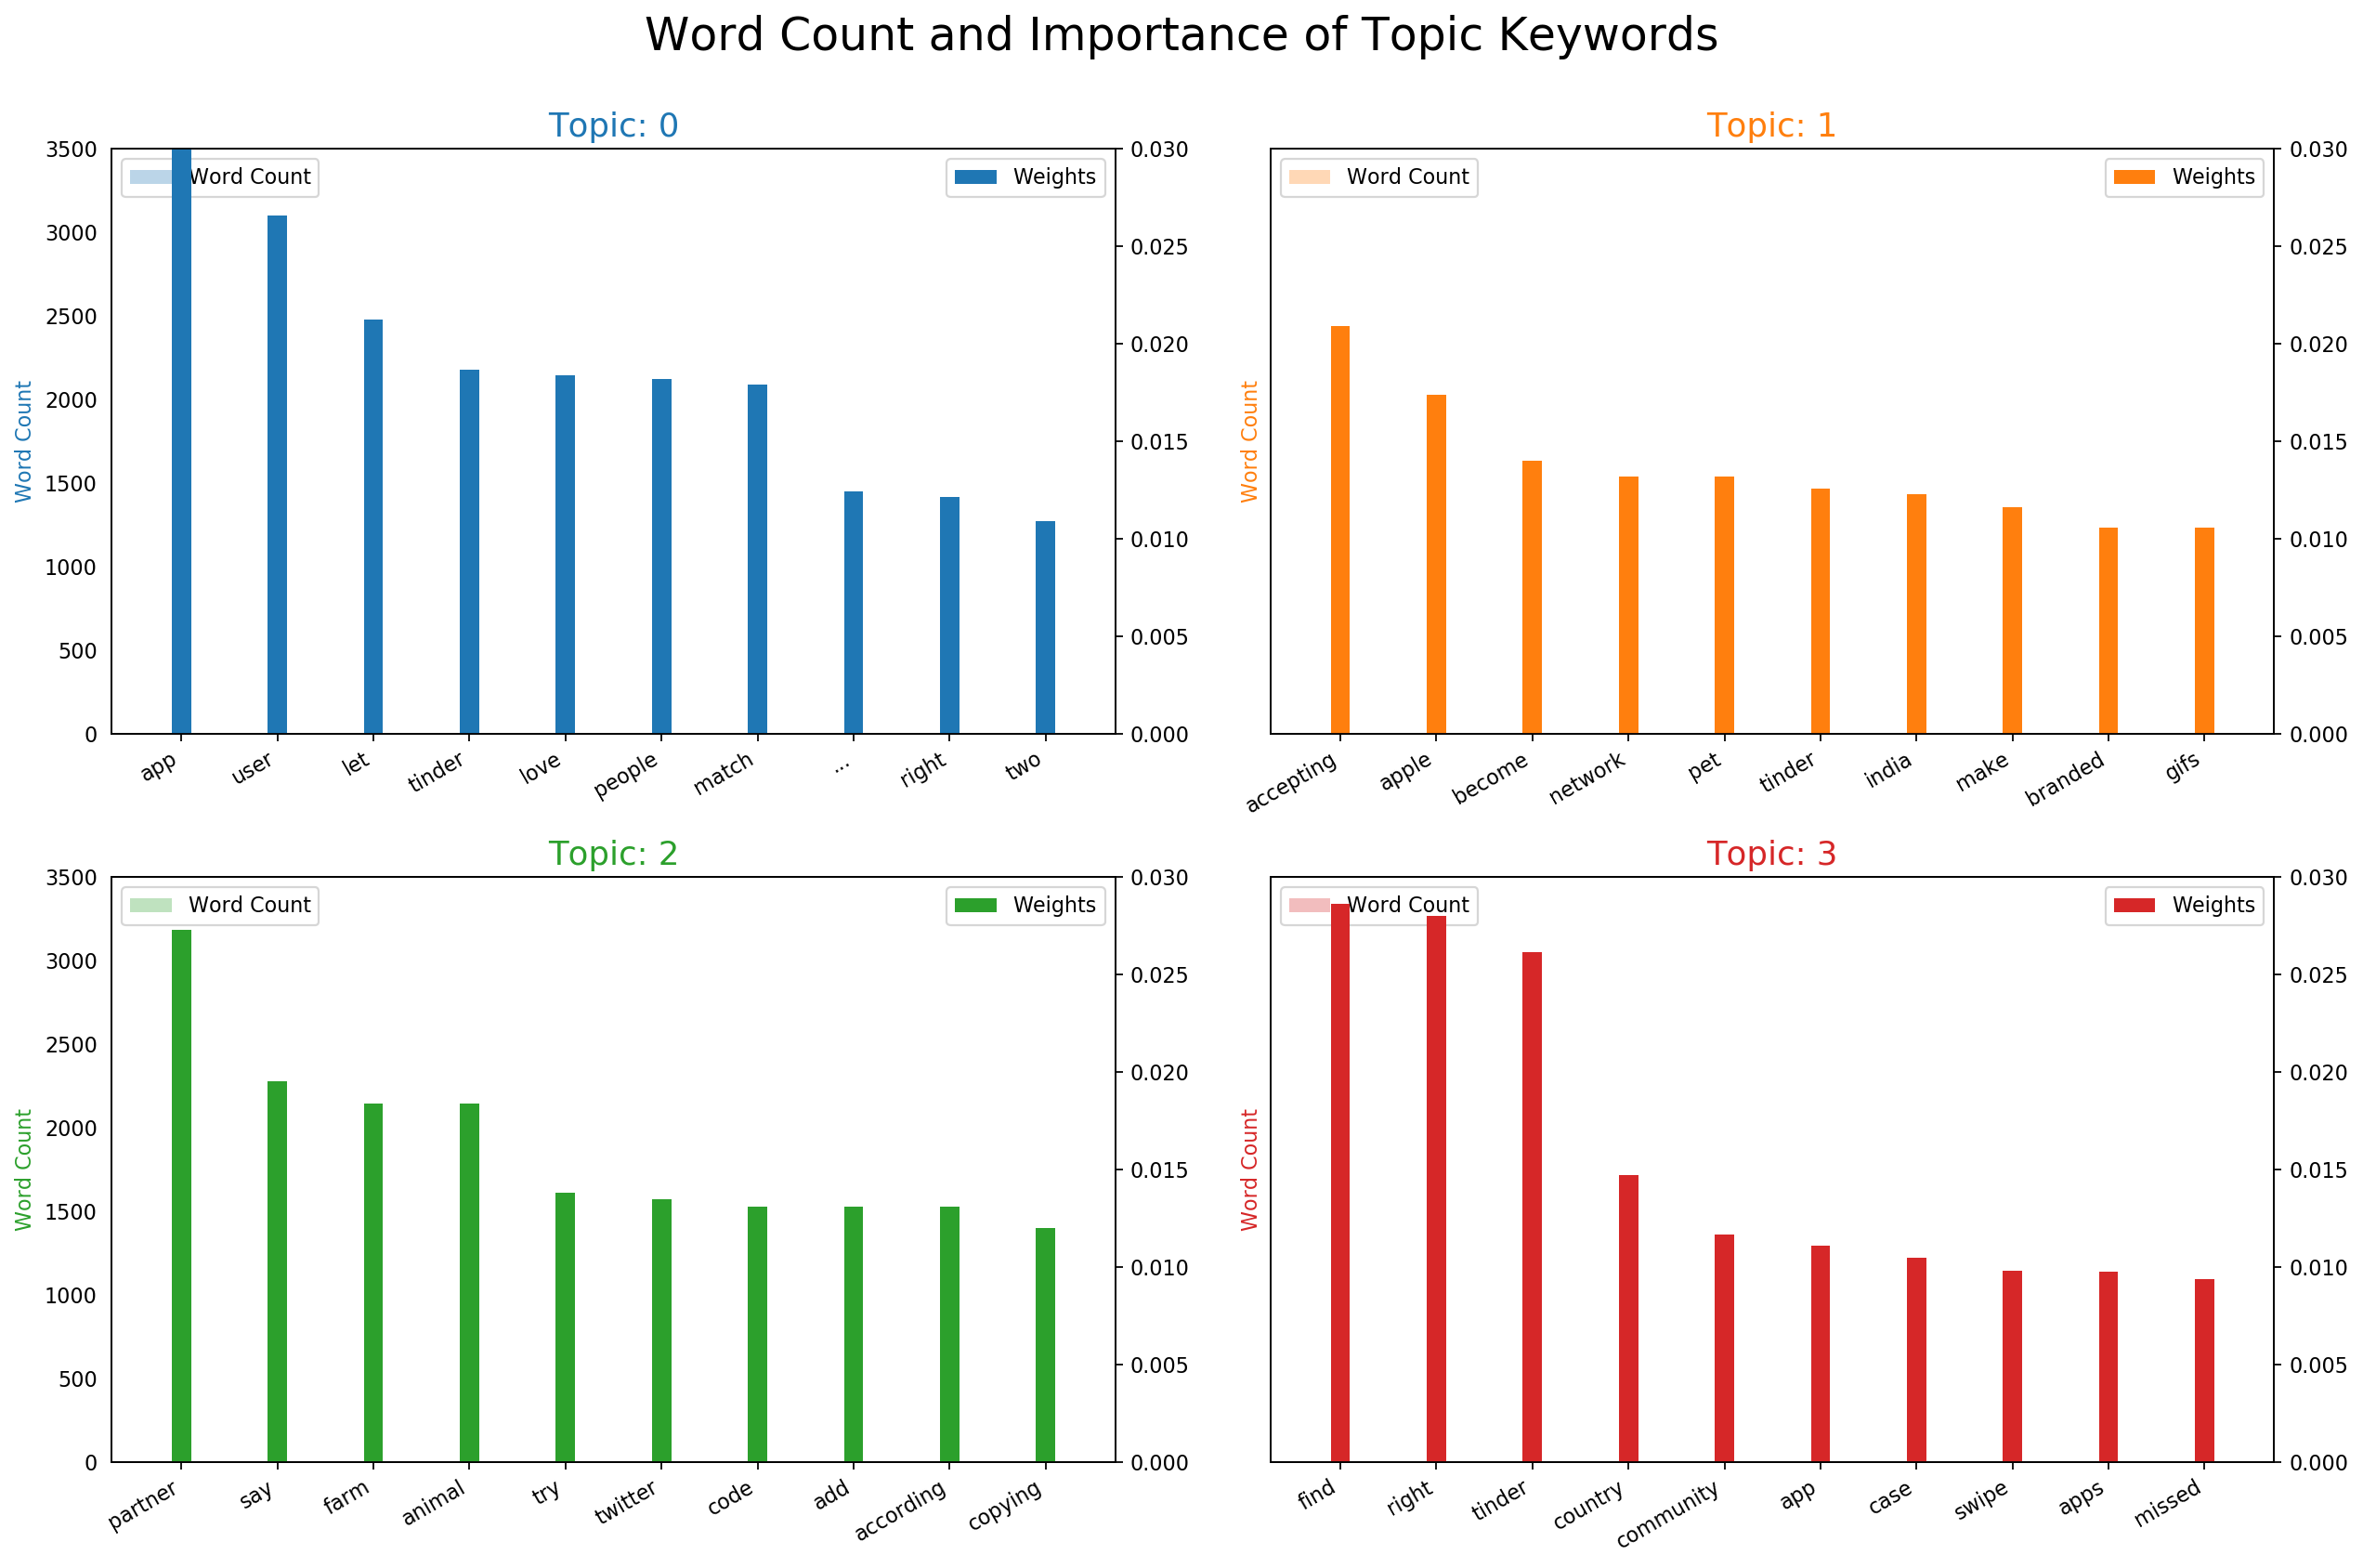

In [83]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

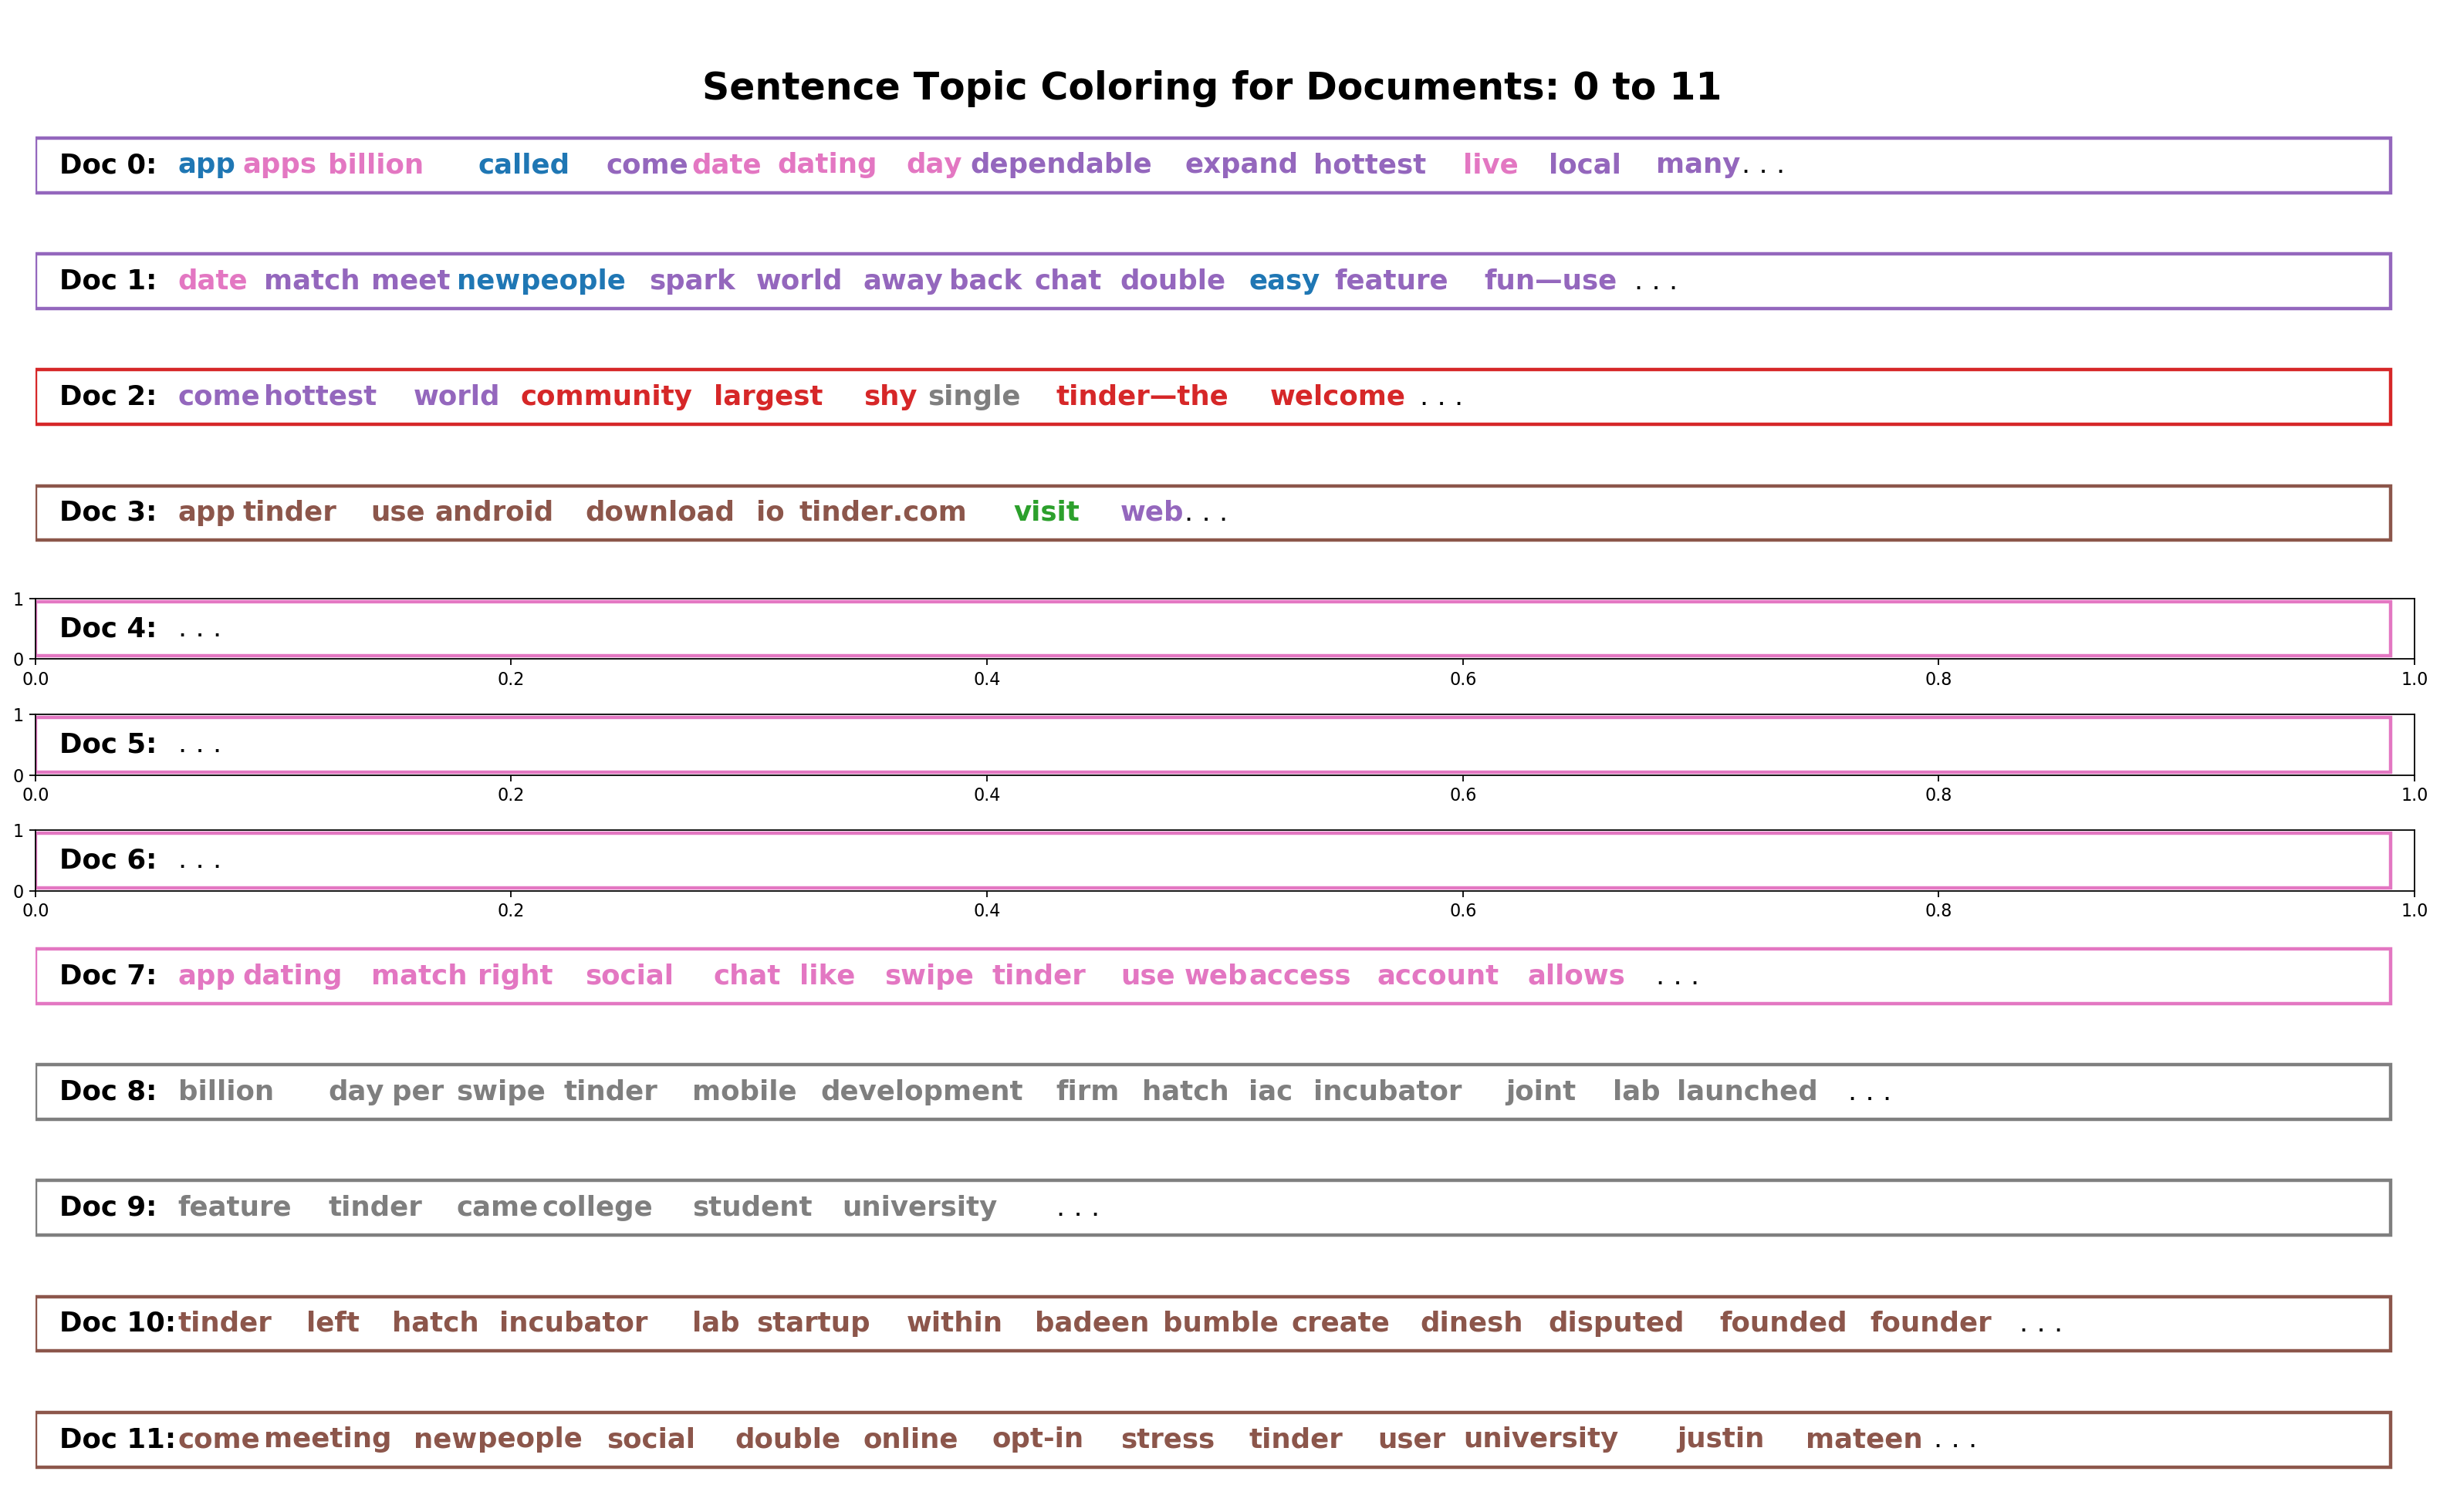

In [84]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=mycorpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            try:
                corp_cur = corp[i-1] 
                topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
                word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
                ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                        fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

                # Draw Rectange
                topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
                ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                       color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

                word_pos = 0.06
                for j, (word, topics) in enumerate(word_dominanttopic):
                    if j < 14:
                        ax.text(word_pos, 0.5, word,
                                horizontalalignment='left',
                                verticalalignment='center',
                                fontsize=16, color=mycolors[topics],
                                transform=ax.transAxes, fontweight=700)
                        word_pos += .009 * len(word)  # to move the word for the next iter
                        ax.axis('off')
                ax.text(word_pos, 0.5, '. . .',
                        horizontalalignment='left',
                        verticalalignment='center',
                        fontsize=16, color='black',
                        transform=ax.transAxes)       
            except:pass
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

In [56]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import numpy as np

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[mycorpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 862 samples in 0.116s...
[t-SNE] Computed neighbors for 862 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 862 / 862
[t-SNE] Mean sigma: 0.023342
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.320713
[t-SNE] KL divergence after 1000 iterations: 0.155918


Loading BokehJS ...